<a href="https://colab.research.google.com/github/ASPIRONOMY/cluster-galaxy-classifier/blob/main/train%20our%20model/cluster_annotation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cluster Galaxy Annotation Tool (Colab)

This notebook lets you **click on an image** to label:
- **Galaxy members** (cluster members) – red markers
- **Background objects** (cluster non-members) – blue markers

Use the buttons below the plot to switch modes. When done, run the last cell to download your results.

## 1. Setup and upload your image

In [5]:
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import csv
import re
import os
from datetime import datetime
from IPython.display import display, clear_output
import ipywidgets as widgets

print("Libraries loaded.")

Libraries loaded.


In [6]:
# Upload your PNG image (or use any image path if you have one in Colab)
uploaded = files.upload()
image_filename = list(uploaded.keys())[0]
print(f"Uploaded: {image_filename}")

Saving cluster_test (1).jpg to cluster_test (1).jpg
Uploaded: cluster_test (1).jpg


## 2. Click to annotate

1. **Switch mode** with the buttons: **Galaxy Members** (red) or **Background Objects** (blue).
2. **Click** on the image to add a point.
3. When finished, run the next cell to save and download results.

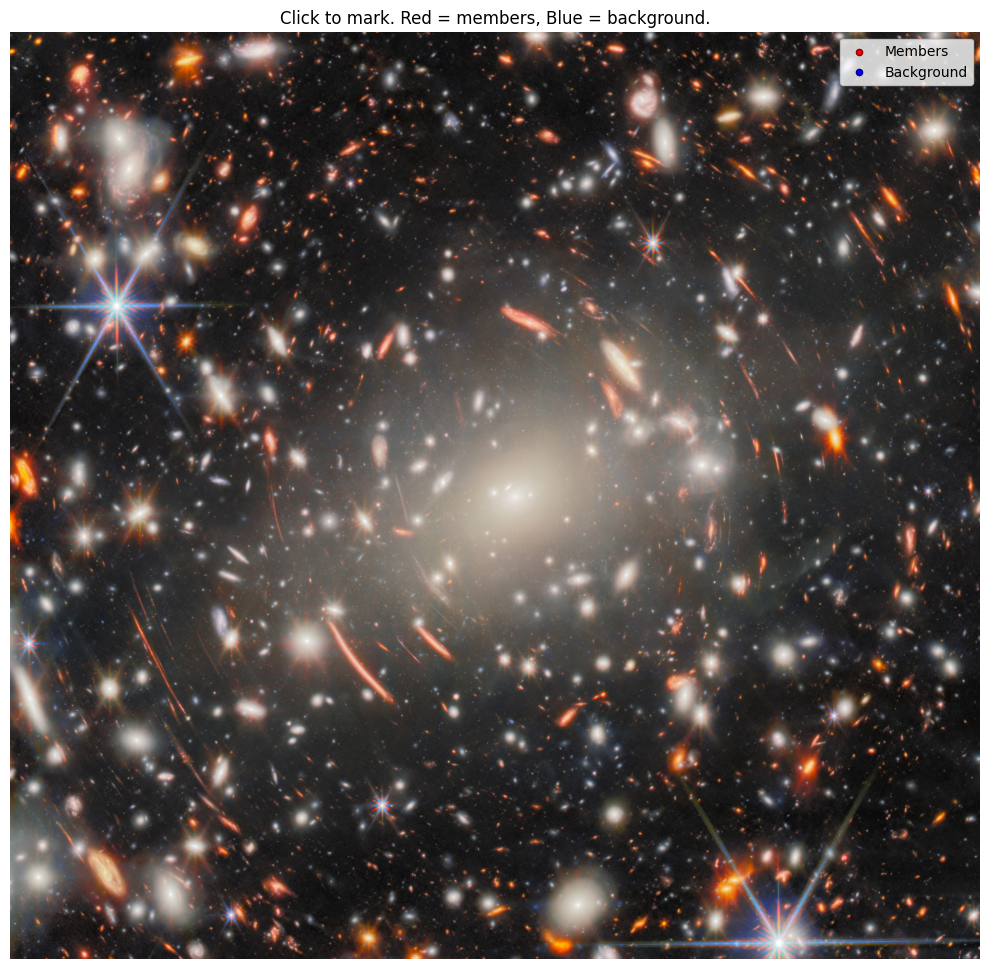

In [7]:
from PIL import ImageDraw

# Load image
img = Image.open(image_filename).convert("RGB")
img_array = np.array(img)
h, w = img_array.shape[:2]

# Storage
members_coords = []   # (x, y) in image pixel coords
non_members_coords = []
current_mode = "members"  # "members" or "non_members"

# Figure and axes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img_array)
ax.set_title("Click to mark. Red = members, Blue = background.")
ax.set_axis_off()

# Scatter artists for live display (we'll update these)
sc_members = ax.scatter([], [], c='red', s=20, edgecolors='darkred', linewidths=1, label='Members')
sc_non = ax.scatter([], [], c='blue', s=20, edgecolors='darkblue', linewidths=1, label='Background')
ax.legend(loc='upper right')

def update_scatter():
    if members_coords:
        xs, ys = zip(*members_coords)
        sc_members.set_offsets(np.c_[xs, ys])
    else:
        sc_members.set_offsets(np.empty((0, 2)))
    if non_members_coords:
        xs, ys = zip(*non_members_coords)
        sc_non.set_offsets(np.c_[xs, ys])
    else:
        sc_non.set_offsets(np.empty((0, 2)))
    fig.canvas.draw_idle()

def on_click(event):
    if event.inaxes != ax or event.xdata is None:
        return
    x, y = int(round(event.xdata)), int(round(event.ydata))
    x = max(0, min(x, w - 1))
    y = max(0, min(y, h - 1))
    if current_mode == "members":
        members_coords.append((x, y))
        print(f"Member #{len(members_coords)}: ({x}, {y})")
    else:
        non_members_coords.append((x, y))
        print(f"Background #{len(non_members_coords)}: ({x}, {y})")
    update_scatter()

fig.canvas.mpl_connect('button_press_event', on_click)

def set_mode_members(_):
    global current_mode
    current_mode = "members"
    status.value = "Mode: Galaxy Members (red)"

def set_mode_non_members(_):
    global current_mode
    current_mode = "non_members"
    status.value = "Mode: Background Objects (blue)"

status = widgets.Label(value="Mode: Galaxy Members (red)")
btn_members = widgets.Button(description="Mark Galaxy Members (M)", style=dict(button_color='lightcoral'))
btn_non = widgets.Button(description="Mark Background Objects (B)", style=dict(button_color='lightblue'))
btn_members.on_click(set_mode_members)
btn_non.on_click(set_mode_non_members)

box = widgets.HBox([status, btn_members, btn_non])
display(box)
plt.tight_layout()
plt.show()

## 3. Save results and download

Run this cell when you are done clicking. It will:
- Create a `cluster_001` folder (or next number)
- Save `image.png`, `cluster_members.csv`, `cluster_non_members.csv`
- Save `image_marked_members.png` and `image_marked_non_members.png`
- Zip the folder and trigger a download.

In [ ]:
import zipfile

# Choose output folder name (cluster_001, cluster_002, ...)
base_dir = "/content"
existing = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and re.match(r'^cluster_\\d{3}$', d)]
nums = [int(re.search(r'\\d{3}$', d).group()) for d in existing if re.search(r'\\d{3}$', d)]
next_num = max(nums, default=0) + 1
folder_name = f"cluster_{next_num:03d}"
out_dir = os.path.join(base_dir, folder_name)
os.makedirs(out_dir, exist_ok=True)
print(f"Output folder: {out_dir}")

# Copy original image
img.save(os.path.join(out_dir, "image.png"))

# Save CSVs
with open(os.path.join(out_dir, "cluster_members.csv"), "w", newline='') as f:
    w = csv.writer(f)
    w.writerow(["X", "Y"])
    w.writerows(members_coords)
with open(os.path.join(out_dir, "cluster_non_members.csv"), "w", newline='') as f:
    w = csv.writer(f)
    w.writerow(["X", "Y"])
    w.writerows(non_members_coords)

# Draw marked images
marker_r = 2
def draw_markers(coords, color_rgb, path):
    out_img = img.copy()
    draw = ImageDraw.Draw(out_img)
    for x, y in coords:
        draw.ellipse([x - marker_r, y - marker_r, x + marker_r, y + marker_r], fill=color_rgb, outline=color_rgb)
    out_img.save(path)

if members_coords:
    draw_markers(members_coords, (255, 0, 0), os.path.join(out_dir, "image_marked_members.png"))
if non_members_coords:
    draw_markers(non_members_coords, (0, 0, 255), os.path.join(out_dir, "image_marked_non_members.png"))

zip_path = os.path.join(base_dir, f"{folder_name}.zip")
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, files in os.walk(out_dir):
        for f in files:
            fp = os.path.join(root, f)
            zf.write(fp, os.path.relpath(fp, base_dir))

print(f"Members: {len(members_coords)}, Non-members: {len(non_members_coords)}")
print("Downloading zip...")
files.download(zip_path)